In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

latent_dims = 2
num_epochs = 100
batch_size = 128
capacity = 64

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
  transforms.ToTensor(),
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    c = capacity

    # Compression of input image
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1)    # c x 14 x 14
    self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1)  # c*2 x 7 x 7

    # Heads for predicting mean vector and diagonal covariance matrix of the latent space
    self.fc_mu = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
    self.fc_logvar = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = x.view(x.size(0), -1)

    x_mu = self.fc_mu(x)
    x_logvar = self.fc_logvar(x)
    return x_mu, x_logvar

class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()
    c = capacity

    # TransposeConv layers for upsampling latent space back to 1 x 28 x 28
    self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*7*7)
    self.upconv1 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
    self.upconv2 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)

  def forward(self, x):
    x = self.fc(x)
    x = x.view(x.size(0), capacity*2, 7, 7)
    x = F.relu(self.upconv1(x))
    x = torch.sigmoid(self.upconv2(x))
    return x

class VAE(nn.Module):
  def __init__(self):
    super(VAE, self).__init__()
    self.encoder = Encoder()
    self.decoder = Decoder()

  def forward(self, x):
    latent_mu, latent_logvar = self.encoder(x)
    latent = self.latent_sample(latent_mu, latent_logvar)
    x_recon = self.decoder(latent)
    return x_recon, latent_mu, latent_logvar

  def latent_sample(self, mu, logvar):
    if self.training:
      std = logvar.mul(0.5).exp_()
      eps = torch.empty_like(std).normal_()
      return eps.mul(std).add(mu)
    else:
      return mu

def vae_loss(recon_x, x, mu, logvar, kl_weight=1):
  recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
  kldiv = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

  return recon_loss + kl_weight * kldiv

In [ ]:
vae = VAE()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vae = vae.to(device)

In [ ]:
def train(model, num_epochs, dataloader):
  optim = torch.optim.Adam(params=model.parameters(), weight_decay=1e-5)

  model.train()
  train_loss = []

  for epoch in range(num_epochs):
    train_loss.append(0)
    num_batches = 0

    for image_batch, _ in dataloader:
      image_batch = image_batch.to(device)
      image_batch_recon, latent_mu, latent_logvar = model(image_batch)
      loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar, kl_weight=2)

      optim.zero_grad()
      loss.backward()
      optim.step()

      train_loss[-1] += loss.item()
      num_batches += 1

    train_loss[-1] /= num_batches

    print(f'Epoch {epoch} / {num_epochs} loss: {train_loss[-1]}')

train(vae, 100, train_dataloader)

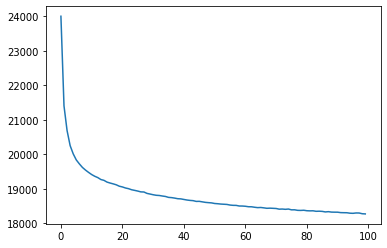

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_loss)

In [ ]:
vae.eval()

test_loss, num_batches = 0, 0
for image_batch, _ in test_dataloader:
  with torch.no_grad():
    image_batch = image_batch.to(device)

    image_batch_recon, latent_mu, latent_logvar = vae(image_batch)
    loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

    test_loss += loss.item()
    num_batches += 1

test_loss /= num_batches
print(f'Average reconstruction error: {test_loss}')

Average reconstruction error: 19195.38096444818


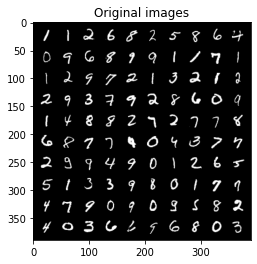

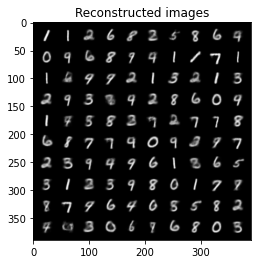

In [ ]:
import torchvision

images, labels = iter(test_dataloader).next()

# Plot original images
grid_img = torchvision.utils.make_grid(images[:100], 10, 10).permute(1, 2, 0)
plt.title('Original images')
plt.imshow(grid_img)
plt.show()

# Plot reconstructed images
images = images.to(device)
with torch.no_grad():
  images, _, _ = vae(images)
images = images.cpu()
grid_img = torchvision.utils.make_grid(images[:100], 10, 10).permute(1, 2, 0)
plt.title('Reconstructed images')
plt.imshow(grid_img)

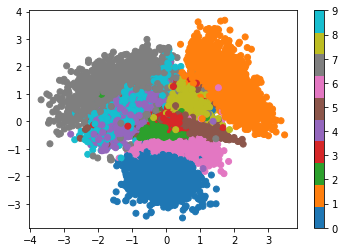

In [ ]:
for i, (x, y) in enumerate(train_dataloader):
  mu, logvar = vae.encoder(x.to(device))
  z = vae.latent_sample(mu, logvar).cpu().detach()
  plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')

  # Run for 100 batches
  if i > 100:
    plt.colorbar()
    break

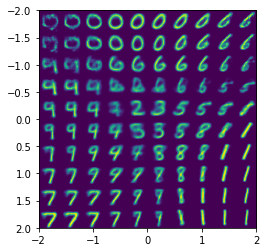

In [ ]:
import numpy as np

img = np.zeros((10*28, 10*28))
for i, y in enumerate(np.linspace(-2, 2, 10)):
  for j, x in enumerate(np.linspace(-2, 2, 10)):
    z = torch.tensor([[x, y]], dtype=torch.float32).to(device)
    recons_img = vae.decoder(z)
    recons_img = recons_img.view(28, 28).detach().cpu()
    img[i*28:(i+1)*28, j*28:(j+1)*28] = recons_img

plt.imshow(img, extent=[-2, 2, 2, -2])

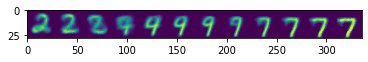

In [ ]:
# Interpolate between the latent vectors of two digits
x, y = iter(train_dataloader).next()
x1 = x[y == 2][0].to(device).unsqueeze(0)
x2 = x[y == 7][0].to(device).unsqueeze(0)

mu1, logvar1 = vae.encoder(x1)
z1 = vae.latent_sample(mu1, logvar1).cpu().detach()

mu2, logvar2 = vae.encoder(x2)
z2 = vae.latent_sample(mu2, logvar2).cpu().detach()

z_inters = torch.stack([z1 + (z2 - z1) * t for t in np.linspace(0, 1, 12)])

img = np.zeros((28, 28*12))
for i, z in enumerate(z_inters):
  recons_img = vae.decoder(z.to(device)).view(28, 28).detach().cpu()
  img[:, i*28:(i+1)*28] = recons_img

plt.imshow(img)

In [ ]:
torch.save(vae.state_dict(), 'vae1.pt')

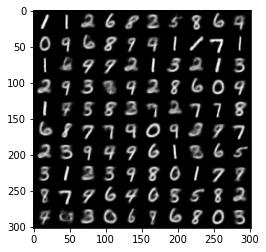

In [ ]:
# Generate new samples
z = torch.randn(128, 2, device=device)
img_recon = vae.decoder(z).cpu()

grid_img = torchvision.utils.make_grid(images[:100], 10).permute(1, 2, 0)
plt.imshow(grid_img)